In [1]:
#*****************************
#** Import the dependencies **
#*****************************

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
#************************
#** Imports, continued **
#************************

import numpy as np
import pandas as pd
import datetime as dt
#delete the below
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [26]:
#*************************************************
#** View all of the classes that automap found  **
#*************************************************

Base.classes.keys()

['measurement', 'station']

In [8]:
#*********************************
# Save references to each table **
#*********************************

Measurement = Base.classes.measurement
Station = Base.classes.station

In [27]:
#****************************************************
#** Create our session (link) from Python to the DB**
#****************************************************
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
#***********************************************
#**Find the most recent date in the data set. **
#***********************************************

measurement_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
measurement_date  #verify the result and ensure it is correct!

('2017-08-23',)

In [28]:
#*************************************************************
#**In this section, parse out the day, month, and year from **
#** the list obtained in the previous step. This obviates   **
#** the need to pass the date as a variable.                **
#*************************************************************

#****************************************************************
#** Note: the result from the step above is a tuple; therefore,**
#** obtain the first element in that touple.                   **
#****************************************************************

date_string = measurement_date[0]

# Convert the date string to a datetime object
date_object = datetime.strptime(date_string, '%Y-%m-%d')

# Extract the month, day, and year from the datetime object
my_month = int(date_object.strftime('%m'))
my_day = int(date_object.strftime('%d'))
my_year = int(date_object.strftime('%Y'))

#*************************************************************
#** use the code below to ensure I get the expected results.**
#*************************************************************

#print("Month:", my_month)
#print("Day:", my_day)
#print("Year:", my_year)

In [29]:
#*******************************************************************
#**Design a query to retrieve the last 12 months of precipitation **
#** data and plot the results. Start from the most recent data    ** 
#** point in the database.                                        ** 
#*******************************************************************

# first, calculate the date one year from the last date in data set.
recent_date = dt.date(my_year,my_month,my_day)
#print(f"Most recent date: {recent_date}")    #verify the expected results were obtained

year_ago = dt.date(my_year,my_month,my_day) - dt.timedelta(days=366)
#print(f"One year prior: {year_ago}")         #verify the expected results were obtained

In [30]:
# second, perform a query to retrieve the data and precipitation scores.
# use the results from the variables in the previos step.

results=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >year_ago).filter(Measurement.date <= recent_date).all()

In [31]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
column_names = ["Measurement Date","Precipitation"]
precipitation_df = pd.DataFrame(results, columns = column_names)
precipitation_df=precipitation_df.sort_values(by="Measurement Date").reset_index(drop=True)
precipitation_df.head()

#Note: I did not drop null values. This doesn't impact the summary statistics or the charts.

,Measurement Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,NaN
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15


<Figure size 800x600 with 0 Axes>

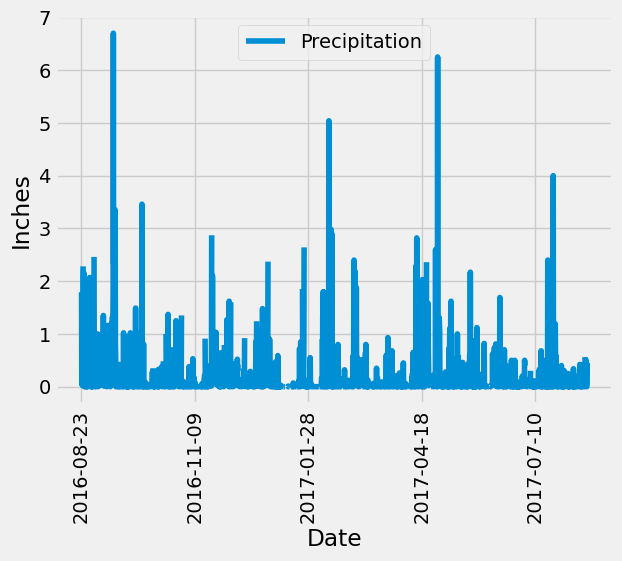

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8, 6))  # Set the figure size
precipitation_df.plot(x='Measurement Date', y= 'Precipitation')
plt.xlabel('Date') #set the label for the x-axis
plt.ylabel('Inches') #set the label for the y-axis
plt.xticks(rotation=90) 
plt.show()  #display the chart

In [34]:
#****************************************************************************
# Use Pandas to calculate the summary statistics for the precipitation data**
#****************************************************************************
summary_stats = precipitation_df['Precipitation'].describe()
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [17]:
#*******************************************
#** Design a query to calculate the total **
#** number of stations in the dataset.    **
#*******************************************

total_count = session.query(Measurement.station).distinct().count()
print(total_count)

9


In [35]:
#******************************************************
# Design a query to find the most active stations,   **
#**(i.e. which stations have the most rows?). List   **
#**the stations and their counts in descending order.**
#******************************************************
active_stations= session.query(Measurement.station,func.count(Measurement.tobs).label('count')).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.tobs).desc()).all()  
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
#****************************************************************
#** We are to design a query to get the previous 12-months' of **
#** tempberature observations (TOBS) data that filters by the  **
#** station tht has the greatest number of observations.       **
#****************************************************************

most_active_station= session.query(Measurement.station,func.count(Measurement.tobs).label('count')).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.tobs).desc()).first()  

#save the most active station as a variable, and check it against the results from the preceding query.
station_id = most_active_station.station
station_id

#find the metrics of interest
most_active_statistics = session.query(func.min(Measurement.tobs).label('min_value'),
                                        func.max(Measurement.tobs).label('max_value'),
                                        func.avg(Measurement.tobs).label('avg_value'))\
                                 .filter(Measurement.station == station_id)\
                                 .first()
#print the results
print(most_active_statistics)

(54.0, 85.0, 71.66378066378067)


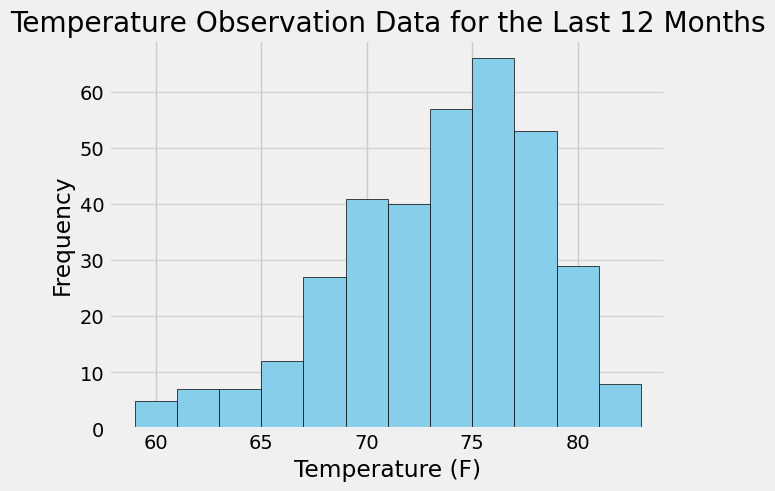

In [37]:
#*************************************************
#** From the results above, retrieve the last   **
#** 12 months of TOBS for the most active       **
#** station and plot the results as a histogram.**
#*************************************************

temperatures=session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >year_ago).filter(Measurement.date <= recent_date).filter(Measurement.station == station_id).all()

#Save the query results as a Pandas DataFrame. Explicitly set the column names
column_names = ["Measurement Date","Temperature"]
temps_df = pd.DataFrame(temperatures, columns = column_names)
temps_df.head()

plt.hist(temps_df['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for the Last 12 Months')
plt.grid(axis='y', alpha=0.75)
plt.show()


# Close Session

In [22]:
# Close Session
session.close()